In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from sklearn.metrics import r2_score
from neurodsp.filt import filter_signal
import matplotlib.patches as patches


In [2]:
def get_info(field_num):
    field = []
    for item in range(trial_num):
        field.append(group_data['DATA'][0][item][field_num][0])
    return pd.DataFrame(field)

def load_time_series(subject, session, unit_id):
    #subj_mat = hdf5storage.loadmat(f"Z:\DBS\\{subject}\Preprocessed Data\SpikeSorting\\{subject}_ft_raw_spike.mat")
    subj_mat = hdf5storage.loadmat(f"/Volumes/Nexus/DBS/{subject}/Preprocessed Data/SpikeSorting/{subject}_ft_raw_spike.mat")
    time_data = subj_mat['IFR'][0]['time'][0][int(session-1)][0]
    neural_data = subj_mat['IFR'][0]['trial'][0][int(session-1)][int(unit_id-1)]
    
    time_data = time_data[~np.isnan(neural_data)]
    neural_data = neural_data[~np.isnan(neural_data)]
    
    return time_data, neural_data

def get_df(time_point, neural_data, time_data, after=3.5, before=1.5, fs=1000):
    dfs = []
    time_point = time_point[time_point<time_data.max()-2][time_point>time_data.min()+2]
    for item in time_point:
        for i2 in range(len(neural_data)):
            if time_data[i2] > item:
                dfs.append(neural_data[i2-int(before*fs):i2+int(after*fs)])
                break
    return np.array(dfs)

# function to convert to superscript
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [3]:
#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [4]:
#group_data = hdf5storage.loadmat(r"Z:\Commits\DBS_speech\Dev\U01SpikeAnalysis\data\group_data\group_data_narrow_09082021.mat")
#group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/MGH BML/Sound-induced_STN_activity/manuscript/group_data_narrow_09082021.mat")
group_data = hdf5storage.loadmat(r"../../../../Macintosh HD/Users/yanming/Desktop/stn_auditory/group_data_narrow_09082021.mat")

trial_num = len(group_data['DATA'][0])

SubjectID = get_info(0)
SubjectID.columns = ['SubjectID']

session = get_info(1)
session.columns = ['session']

electrode = get_info(2)
electrode.columns = ['electrode']

unit_id = get_info(3)
unit_id.columns = ['unit_id']

unit = get_info(4)
unit.columns = ['unit']

RecType = get_info(5)
RecType.columns = ['RecType']

grade = get_info(6)
grade.columns = ['grade']

info = pd.concat([SubjectID, session, electrode, unit_id, unit, RecType, grade], axis=1)
info.head(2)
info.shape

,SubjectID,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,1,micro_m,6,4,MU,B
1,DBS3001,2,micro_c,7,1,MU,C


(229, 7)

In [5]:
def get_produced_phoneme(subject):
    #produced_phoneme = pd.read_csv(f'Z:\DBS\\{subject}\Preprocessed Data\Sync\\annot\\{subject}_produced_phoneme.txt', sep='	', index_col='id')
    produced_phoneme = pd.read_csv(f'/Volumes/Nexus/DBS/{subject}/Preprocessed Data/Sync/annot/{subject}_stimulus_phoneme.txt', sep='	', index_col='id')
    return produced_phoneme

def nansem(a, axis=1):
    return np.nanstd(a, axis=0)/np.sqrt(a.shape[axis])
def find_full_3_trial(subj_table, timing_subj):
    good_trial = []
    subj_table = subj_table.dropna()
    subj_table = subj_table[subj_table['starts'] > timing_subj.min() + 4.5]
    subj_table = subj_table[subj_table['ends'] < timing_subj.max() - 4.5]
    for item in subj_table['trial_id'].unique():
        if subj_table[subj_table['trial_id'] == item].shape[0] == 3:
            good_trial.append(item)
    return subj_table[subj_table['trial_id'].isin(good_trial)]

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import StratifiedKFold


In [11]:
number_elec = 184
SUBJECT = info.iloc[number_elec, 0]
session = info.iloc[number_elec, 1]
contact = info.iloc[number_elec, 3]

timing, neural_df = load_time_series(SUBJECT, session, contact)

cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
cue_df = cue_df.iloc[:, :6]
cue_df = cue_df[cue_df.session_id==session].dropna()


subj_df = get_produced_phoneme(SUBJECT)
subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

subj_df_cue_speech['cv'] = subj_df_cue_speech['stim_y'] + subj_df_cue_speech['stim_x']
subj_df_cue_speech['cv'].unique()

array(['tee', 'soo', 'vah', 'sah', 'ghoo', 'ghah', 'voo', 'see', 'too',
       'tah', 'ghee', 'vee'], dtype=object)

In [12]:
cv_label_all = pd.DataFrame()
spike_mat_cv_all = []

item = subj_df_cue_speech['cv'].unique()[0]
speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
cv_label = np.repeat(item, len(speech_onset_cv))
cv_label_all = pd.DataFrame({'label':cv_label})
spike_mat_cv_all = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=0)
spike_mat_cv_all = pd.DataFrame(spike_mat_cv_all)

for item in subj_df_cue_speech['cv'].unique()[1:]:
    speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
    cv_label = np.repeat(item, len(speech_onset_cv))
    cv_label = pd.DataFrame({'label':cv_label})
    cv_label_all = pd.concat([cv_label_all, cv_label])
    spike_mat_cv = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=0)
    spike_mat_cv = pd.DataFrame(spike_mat_cv)
    spike_mat_cv_all = pd.concat([spike_mat_cv_all, spike_mat_cv])

    
cv_label_all = cv_label_all.reset_index(drop=1)
spike_mat_cv_all = spike_mat_cv_all.reset_index(drop=1)

In [13]:
X = spike_mat_cv_all      # shape (345, 500)
y = cv_label_all.values.ravel()  # ensure it's 1D

In [14]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

In [15]:
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    results[name] = (np.mean(scores), np.std(scores))

In [17]:
# Extract model names
model_names = list(results.keys())

# Extract mean accuracy and std accuracy into separate lists
mean_accuracies = [v[0] for v in results.values()]
std_accuracies = [v[1] for v in results.values()]

# Create two DataFrames
df_mean_acc = pd.DataFrame(mean_accuracies, index=model_names, columns=["C1"])
df_std_acc = pd.DataFrame(std_accuracies, index=model_names, columns=["C1"])

In [18]:
df_mean_acc

,C1
Logistic Regression,0.086957
SVM (RBF Kernel),0.133333
Random Forest,0.130435
Gradient Boosting,0.121739
Naive Bayes,0.150725
KNN,0.110145
Decision Tree,0.133333


In [19]:
df_std_acc

,C1
Logistic Regression,0.018332
SVM (RBF Kernel),0.042402
Random Forest,0.037792
Gradient Boosting,0.026880
Naive Bayes,0.037345
KNN,0.026880
Decision Tree,0.043382


In [561]:
def get_zscore(input_mat):
    rest_mat = input_mat[:, :1000]
    input_mat_z = np.zeros(input_mat.shape)
    for item in range(rest_mat.shape[0]):
        rest_mean = rest_mat[item].mean()
        rest_sd = np.nanstd(rest_mat[item])
        input_mat_z[item] = (input_mat[item] - rest_mean)/rest_sd
    return input_mat_z

In [563]:
def get_acc(number_elec):
    print(number_elec)
    
    # Load data
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]

    timing, neural_df = load_time_series(SUBJECT, session, contact)

    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df.iloc[:, :6]
    cue_df = cue_df[cue_df.session_id==session].dropna()


    subj_df = get_produced_phoneme(SUBJECT)
    subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
    subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
    subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
    subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
    subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    subj_df_cue_speech['cv'] = subj_df_cue_speech['stim_y'] + subj_df_cue_speech['stim_x']

    
    # Get X Y
    item = subj_df_cue_speech['cv'].unique()[0]
    speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
    cv_label = np.repeat(item, len(speech_onset_cv))
    cv_label_all = pd.DataFrame({'label':cv_label})
    spike_mat_cv_all = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=1)
    spike_mat_cv_all = get_zscore(spike_mat_cv_all)[:, 1100:1300]
    spike_mat_cv_all = pd.DataFrame(spike_mat_cv_all)

    for item in subj_df_cue_speech['cv'].unique()[1:]:
        speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
        cv_label = np.repeat(item, len(speech_onset_cv))
        cv_label = pd.DataFrame({'label':cv_label})
        cv_label_all = pd.concat([cv_label_all, cv_label])
        spike_mat_cv = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=1)
        spike_mat_cv = get_zscore(spike_mat_cv)[:, 1100:1300]
        spike_mat_cv = pd.DataFrame(spike_mat_cv)
        spike_mat_cv_all = pd.concat([spike_mat_cv_all, spike_mat_cv])


    cv_label_all = cv_label_all.reset_index(drop=1)
    spike_mat_cv_all = spike_mat_cv_all.reset_index(drop=1)
    
    
    # ML
    X = spike_mat_cv_all
    y = cv_label_all.values.ravel()

    
    classifiers = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
        "Random Forest": RandomForestClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(),
        "Naive Bayes": GaussianNB(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier()
    }
    results = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        pipeline = make_pipeline(StandardScaler(), clf)
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
        results[name] = (np.mean(scores), np.std(scores))
    
    # Extract model names
    model_names = list(results.keys())

    # Extract mean accuracy and std accuracy into separate lists
    mean_accuracies = [v[0] for v in results.values()]
    std_accuracies = [v[1] for v in results.values()]

    # Create two DataFrames
    df_mean_acc_elec = pd.DataFrame(mean_accuracies, 
                                    index=model_names, columns=[number_elec])
    df_std_acc_elec = pd.DataFrame(std_accuracies, 
                                   index=model_names, columns=[number_elec])
    
    return df_mean_acc_elec, df_std_acc_elec
    

In [569]:
#sig_diff_cv = np.array([28, 48, 122, 176, 184, 185, 189, 199, 30, 129, 168])
sig_diff_cv = np.array([28, 122, 176, 184, 185, 189, 199, 30, 129, 168])


In [570]:
df_mean_acc_all, df_std_acc_all = get_acc(sig_diff_cv[0])

for item in sig_diff_cv[1:]:
    df_mean_acc, df_std_acc = get_acc(item)
    
    df_mean_acc_all = pd.concat([df_mean_acc_all, df_mean_acc], axis=1)
    df_std_acc_all = pd.concat([df_std_acc_all, df_std_acc], axis=1)

28
122
176
184
185
189
199
30
129
168


In [577]:
df_mean_acc_all = df_mean_acc_all.rename(columns={28:'CV1', 122:'CV2', 
                                                   176:'CV3', 184:'CV4', 
                                                   185:'CV5', 189:'CV6', 
                                                   199:'CV7', 30:'CV8', 
                                                   129:'CV9', 168:'CV10'})
df_mean_acc_all

,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
Logistic Regression,0.104221,0.115942,0.150055,0.107246,0.095652,0.120126,0.153968,0.076299,0.113964,0.138095
SVM (RBF Kernel),0.114610,0.101449,0.122259,0.144928,0.107246,0.127673,0.105684,0.065195,0.079718,0.111429
Random Forest,0.114675,0.084058,0.122148,0.121739,0.089855,0.093711,0.096057,0.094351,0.108249,0.055238
Gradient Boosting,0.085974,0.121739,0.122148,0.130435,0.110145,0.105031,0.095955,0.076234,0.122616,0.083810
Naive Bayes,0.139740,0.115942,0.122259,0.115942,0.098551,0.104962,0.108858,0.083377,0.079839,0.083810
KNN,0.096818,0.101449,0.117497,0.113043,0.066667,0.108945,0.083205,0.119740,0.085433,0.096190
Decision Tree,0.082468,0.086957,0.103322,0.104348,0.110145,0.097554,0.083359,0.075974,0.093924,0.109524


In [578]:
df_mean_acc_all_plot = df_mean_acc_all.reset_index().melt(id_vars='index', 
                                                          var_name='Unit', 
                                                          value_name='Score')
df_mean_acc_all_plot.rename(columns={'index': 'Classifier'}, inplace=True)


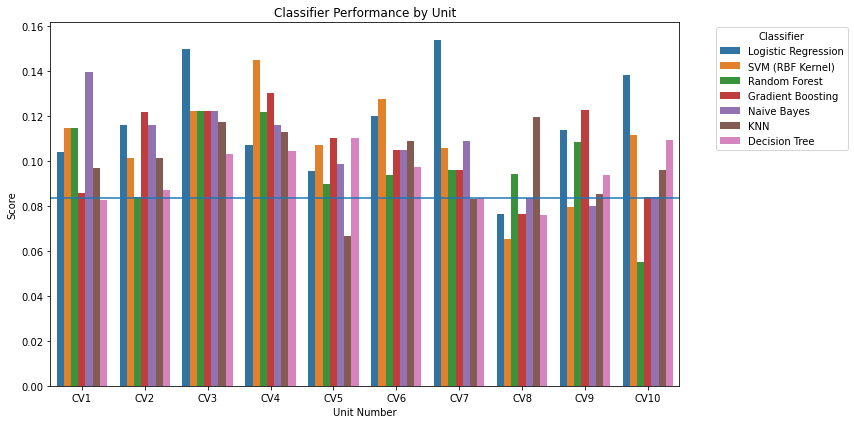

In [579]:
# Step 2: Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mean_acc_all_plot, x='Unit', y='Score', hue='Classifier')

# Step 3: Beautify the plot
plt.title('Classifier Performance by Unit')
plt.xlabel('Unit Number')
plt.ylabel('Score')
plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.axhline(1/12)
plt.show();

In [248]:
# Combine all data
def get_combined_data(number_elec):
    
    print(number_elec)
    
    # Load data
    SUBJECT = info.iloc[number_elec, 0]
    session = info.iloc[number_elec, 1]
    contact = info.iloc[number_elec, 3]

    timing, neural_df = load_time_series(SUBJECT, session, contact)

    cue_df = pd.read_csv(f'/Volumes/Nexus/DBS/{SUBJECT}/Preprocessed Data/Sync/annot/{SUBJECT}_stimulus_syllable.txt', sep='	', index_col='id')
    cue_df = cue_df.iloc[:, :6]
    cue_df = cue_df[cue_df.session_id==session].dropna()


    subj_df = get_produced_phoneme(SUBJECT)
    subj_df_vowel = subj_df[subj_df['type'] == "vowel"]
    subj_df_consonant = subj_df[subj_df['type'] == "consonant"]
    subj_df_vowel = find_full_3_trial(subj_df_vowel, timing).reset_index(drop=1)
    subj_df_consonant = subj_df_consonant[["session_id", "trial_id", "syl_id", "stim"]]
    subj_df_vowel = subj_df_vowel.merge(subj_df_consonant, on=['session_id', 'trial_id', 'syl_id'], how="inner")
    subj_df_cue_speech = subj_df_vowel.merge(cue_df, on=['session_id', 'trial_id', 'syl_id'], how="inner")

    subj_df_cue_speech['cv'] = subj_df_cue_speech['stim_y'] + subj_df_cue_speech['stim_x']

    
    # Get X Y
    cv_label_all = pd.DataFrame()
    spike_mat_cv_all = []

    item = subj_df_cue_speech['cv'].unique()[0]
    speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
    cv_label = np.repeat(item, len(speech_onset_cv))
    cv_label_all = pd.DataFrame({'label':cv_label})
    spike_mat_cv_all = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=1)
    spike_mat_cv_all = get_zscore(spike_mat_cv_all)[:, 1100:1300]
    spike_mat_cv_all = pd.DataFrame(spike_mat_cv_all)

    for item in subj_df_cue_speech['cv'].unique()[1:]:
        speech_onset_cv = subj_df_cue_speech[subj_df_cue_speech['cv'] == item]['starts_y']
        cv_label = np.repeat(item, len(speech_onset_cv))
        cv_label = pd.DataFrame({'label':cv_label})
        cv_label_all = pd.concat([cv_label_all, cv_label])
        spike_mat_cv = get_df(speech_onset_cv, neural_df, timing, after=0.5, before=1)
        spike_mat_cv = get_zscore(spike_mat_cv)[:, 1100:1300]
        spike_mat_cv = pd.DataFrame(spike_mat_cv)
        spike_mat_cv_all = pd.concat([spike_mat_cv_all, spike_mat_cv])


    cv_label_all = cv_label_all.reset_index(drop=1)
    spike_mat_cv_all = spike_mat_cv_all.reset_index(drop=1)
    
    
    X_combined = []
    Y_combined = []
    print(cv_label_all['label'].value_counts())

    for label in cv_label_all['label'].unique():
        # Get first 20 samples for this label in each dataset
        idx1 = cv_label_all[cv_label_all == label].dropna().index[:15]

        # Extract and append
        X_combined.append(spike_mat_cv_all.loc[idx1])
        Y_combined.append(cv_label_all.loc[idx1])

    X_final = pd.concat(X_combined, ignore_index=True)
    Y_final = pd.concat(Y_combined, ignore_index=True)
    
    return X_final, Y_final



In [249]:
X_final_all, Y_final_all = get_combined_data(sig_diff_cv[0])
final_mat = pd.concat([Y_final_all, X_final_all], axis=1)
final_mat = final_mat.sort_values(by='label').reset_index(drop=1)

for item in sig_diff_cv[1:-1]:
    X_final_elec, Y_final_elec = get_combined_data(item)
    elec_mat = pd.concat([Y_final_elec, X_final_elec], axis=1)
    elec_mat = elec_mat.sort_values(by='label').reset_index(drop=1).iloc[:, 1:]
    final_mat = pd.concat([final_mat, elec_mat], axis=1)
    

28
label
tah     25
soo     25
ghoo    25
vah     24
tee     24
vee     23
ghah    23
voo     23
see     22
ghee    22
sah     22
too     21
Name: count, dtype: int64
48
label
tee     30
soo     30
vah     30
sah     30
ghoo    30
ghah    30
voo     30
see     30
too     30
tah     30
ghee    30
vee     30
Name: count, dtype: int64
122
label
vah     30
too     30
see     30
vee     30
soo     30
tee     30
ghah    29
ghoo    29
sah     29
tah     27
voo     26
ghee    25
Name: count, dtype: int64
176
label
too     21
ghah    19
vah     19
tah     19
ghee    19
tee     18
sah     17
soo     17
voo     17
see     16
ghoo    16
vee     15
Name: count, dtype: int64
184
label
soo     30
vah     30
vee     30
tee     29
ghoo    29
ghah    29
see     29
too     29
tah     29
sah     28
voo     27
ghee    26
Name: count, dtype: int64
185
label
soo     30
vah     30
vee     30
tee     29
ghoo    29
ghah    29
see     29
too     29
tah     29
sah     28
voo     27
ghee    26
Name: count, dtype: 

In [250]:
final_mat.shape

(180, 2001)

In [257]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [265]:
np.array(final_mat.iloc[:, 1:]).shape

(180, 2000)

In [288]:

# Step 2: Apply PCA to reduce to 200 components
pca = PCA(n_components=50)
final_mat_reduced = pca.fit_transform(np.array(final_mat.iloc[:, 1:]))  # shape: (180, 200)
final_mat_reduced.shape

(180, 50)

In [289]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [392]:
X = final_mat.iloc[:, 1:]
y = final_mat['label']



lda = LinearDiscriminantAnalysis()
final_mat_lda = lda.fit_transform(np.array(final_mat.iloc[:, 1:]), 
                                                        final_mat['label'])

In [613]:
final_mat.iloc[:, :]

,label,0,1,2,3,4,5,6,7,8,...,190,191,192,193,194,195,196,197,198,199
0,ghah,0.047238,0.079614,0.111465,0.142725,0.173330,0.203219,0.232334,0.260619,0.288025,...,1.996461,1.976819,1.955541,1.932940,1.908498,1.882491,1.854947,1.825899,1.795382,1.763435
1,ghah,2.115309,2.188371,2.259524,2.328559,2.395270,2.459451,2.520489,2.579064,2.634497,...,-0.252954,-0.217396,-0.182340,-0.147662,-0.113492,-0.079962,-0.047199,-0.015331,0.015517,0.045223
2,ghah,-0.951449,-0.951449,-0.951449,-0.951449,-0.951449,-0.951449,-0.951449,-0.951449,-0.951449,...,1.171248,1.221344,1.271317,1.320912,1.369861,1.417887,1.464705,1.510029,1.553566,1.595025
3,ghah,0.761606,0.822404,0.882116,0.940515,0.997371,1.052456,1.105543,1.156413,1.204846,...,-2.306849,-2.321057,-2.333477,-2.344153,-2.353127,-2.360435,-2.366110,-2.370181,-2.372674,-2.373607
4,ghah,-0.075453,-0.106221,-0.134485,-0.160264,-0.183583,-0.204471,-0.222957,-0.239073,-0.252854,...,1.654421,1.684534,1.715335,1.746628,1.778209,1.809867,1.841382,1.872532,1.903089,1.932826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,voo,-0.331809,-0.367736,-0.402608,-0.436376,-0.469000,-0.500447,-0.530691,-0.559715,-0.587506,...,-0.100039,-0.076977,-0.054703,-0.032859,-0.011819,0.008312,0.027435,0.045460,0.062304,0.077897
176,voo,-0.556460,-0.543078,-0.528586,-0.513353,-0.497458,-0.480984,-0.464017,-0.446644,-0.428955,...,6.088511,6.095747,6.102597,6.108838,6.114240,6.118571,6.121597,6.123088,6.122812,6.120546
177,voo,-1.073337,-1.073337,-1.073337,-1.073337,-1.073337,-1.073337,-1.073337,-1.073337,-1.073337,...,-0.895281,-0.877975,-0.860127,-0.841798,-0.823049,-0.803947,-0.784555,-0.764944,-0.745180,-0.725334
178,voo,4.349976,4.360009,4.365995,4.367858,4.365529,4.358948,4.348062,4.332830,4.313220,...,0.373495,0.349625,0.327019,0.305803,0.286094,0.267999,0.251618,0.237042,0.224351,0.213615


In [614]:
final_mat.to_csv('../Classification_input.csv')

In [471]:
X = final_mat.iloc[:, 1:]
y = final_mat['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.6
)

lda = LinearDiscriminantAnalysis()
X_test_lda = lda.fit(X_train, y_train).transform(X)


In [472]:
# ML
X = X_test_lda
y = y

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    results[name] = (np.mean(scores), np.std(scores))

# Extract model names
model_names = list(results.keys())

# Extract mean accuracy and std accuracy into separate lists
mean_accuracies = [v[0] for v in results.values()]
std_accuracies = [v[1] for v in results.values()]

# Create two DataFrames
df_mean_acc_elec = pd.DataFrame(mean_accuracies, 
                                index=model_names, columns=['Combined'])
df_std_acc_elec = pd.DataFrame(std_accuracies, 
                               index=model_names, columns=['Combined'])

In [473]:
df_mean_acc_elec

,Combined
Logistic Regression,0.416667
SVM (RBF Kernel),0.450000
Random Forest,0.433333
Gradient Boosting,0.383333
Naive Bayes,0.361111
KNN,0.472222
Decision Tree,0.294444


In [611]:
df_std_acc_elec

,Combined
Logistic Regression,0.058267
SVM (RBF Kernel),0.096864
Random Forest,0.100308
Gradient Boosting,0.075359
Naive Bayes,0.039284
KNN,0.070273
Decision Tree,0.057198


In [580]:
df_mean_acc_combined_all = pd.concat([df_mean_acc_elec, df_mean_acc_all], axis=1)
df_std_acc_combined_all = pd.concat([df_std_acc_elec, df_std_acc_all], axis=1)

df_mean_acc_combined_all_plot = df_mean_acc_combined_all.reset_index().melt(id_vars='index', 
                                                          var_name='Unit', 
                                                          value_name='Score')
df_mean_acc_combined_all_plot.rename(columns={'index': 'Classifier'}, inplace=True)


In [581]:
df_mean_acc_all
df_mean_acc_combined_all_plot

,CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
Logistic Regression,0.104221,0.115942,0.150055,0.107246,0.095652,0.120126,0.153968,0.076299,0.113964,0.138095
SVM (RBF Kernel),0.114610,0.101449,0.122259,0.144928,0.107246,0.127673,0.105684,0.065195,0.079718,0.111429
Random Forest,0.114675,0.084058,0.122148,0.121739,0.089855,0.093711,0.096057,0.094351,0.108249,0.055238
Gradient Boosting,0.085974,0.121739,0.122148,0.130435,0.110145,0.105031,0.095955,0.076234,0.122616,0.083810
Naive Bayes,0.139740,0.115942,0.122259,0.115942,0.098551,0.104962,0.108858,0.083377,0.079839,0.083810
KNN,0.096818,0.101449,0.117497,0.113043,0.066667,0.108945,0.083205,0.119740,0.085433,0.096190
Decision Tree,0.082468,0.086957,0.103322,0.104348,0.110145,0.097554,0.083359,0.075974,0.093924,0.109524


,Classifier,Unit,Score
0,Logistic Regression,Combined,0.416667
1,SVM (RBF Kernel),Combined,0.450000
2,Random Forest,Combined,0.433333
3,Gradient Boosting,Combined,0.383333
4,Naive Bayes,Combined,0.361111
...,...,...,...
72,Random Forest,CV10,0.055238
73,Gradient Boosting,CV10,0.083810
74,Naive Bayes,CV10,0.083810
75,KNN,CV10,0.096190


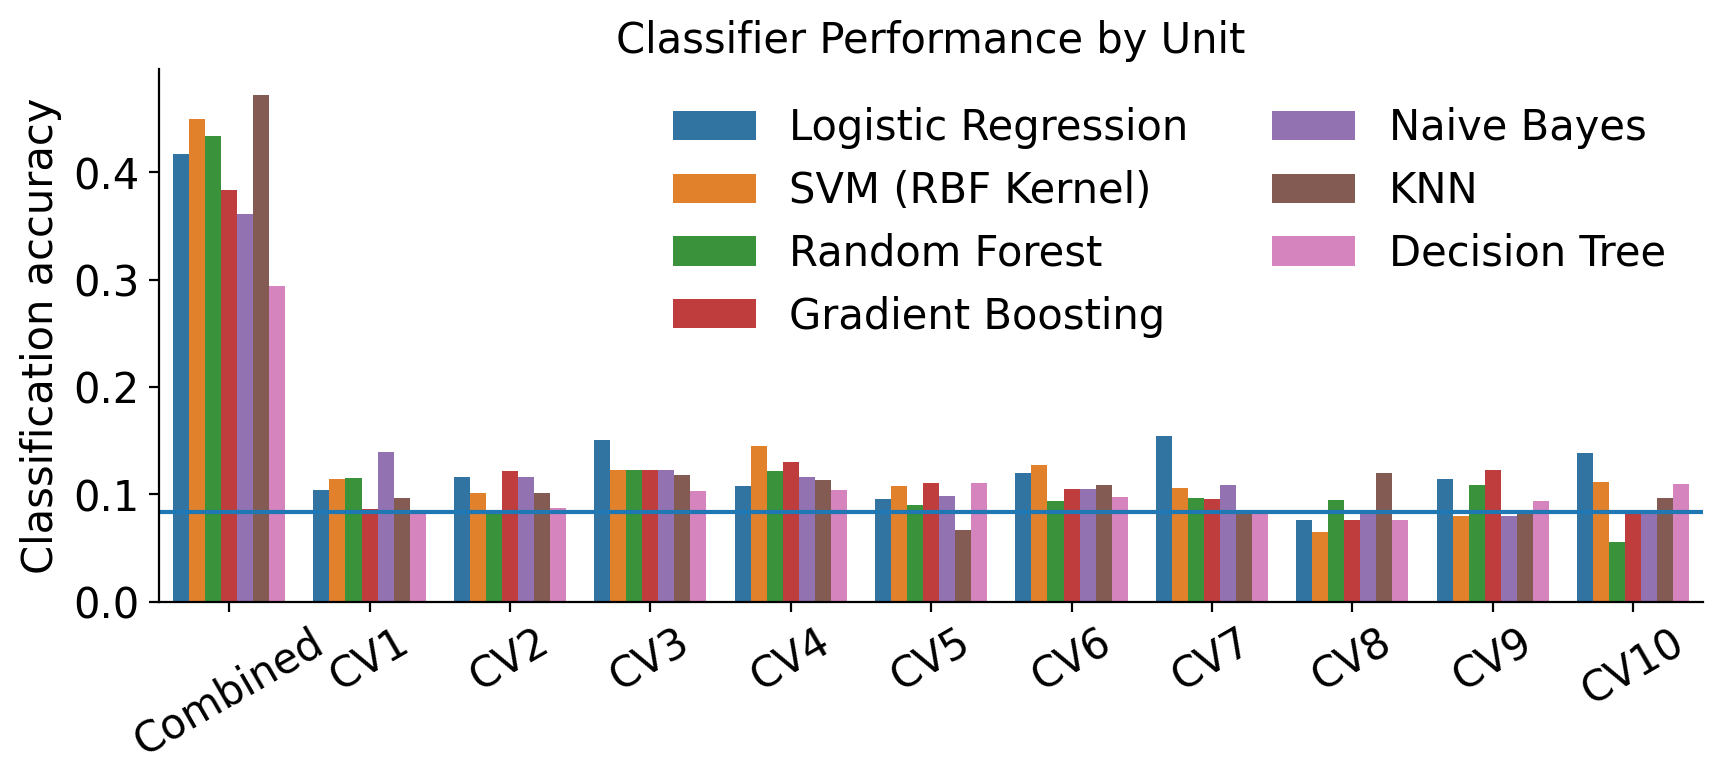

In [610]:
fig, axs = plt.subplots(1, 1, figsize=(8.5, 3.8), dpi=200, constrained_layout=True)
fig.patch.set_alpha(0)

axs.patch.set_alpha(0)

# Step 2: Plot using seaborn
sns.barplot(data=df_mean_acc_combined_all_plot, 
            x='Unit', y='Score', hue='Classifier', 
            ax=axs)

# Step 3: Beautify the plot
axs.set_title('Classifier Performance by Unit', fontsize=15)
axs.set_xlabel(None)
axs.set_ylabel('Classification accuracy', fontsize=15)
axs.legend(loc='upper right', fontsize=15, ncol=2, frameon=0)
axs.axhline(1/12)
sns.despine(ax=axs,
    top=True,
    right=True,
    left=False,
    bottom=False)
axs.set_yticklabels(axs.get_yticklabels(), fontsize=15)
axs.set_xticklabels(axs.get_xticklabels(), fontsize=15, rotation=30)

plt.show();

In [605]:
axs.get_yticklabels()

[Text(0, 0.0, '0.0'),
 Text(0, 0.1, '0.1'),
 Text(0, 0.2, '0.2'),
 Text(0, 0.30000000000000004, '0.3'),
 Text(0, 0.4, '0.4'),
 Text(0, 0.5, '0.5')]

In [224]:
Y_combined

[   label
 0    vah
 1    vah
 2    vah
 3    vah
 4    vah
 5    vah
 6    vah
 7    vah
 8    vah
 9    vah
 10   vah
 11   vah
 12   vah
 13   vah
 14   vah
 15   vah
 16   vah
 17   vah
 18   vah
 19   vah,
    label
 0    vah
 1    vah
 2    vah
 3    vah
 4    vah
 5    vah
 6    vah
 7    vah
 8    vah
 9    vah
 10   vah
 11   vah
 12   vah
 13   vah
 14   vah
 15   vah
 16   vah
 17   vah
 18   vah
 19   vah,
    label
 0    vah
 1    vah
 2    vah
 3    vah
 4    vah
 5    vah
 6    vah
 7    vah
 8    vah
 9    vah
 10   vah
 11   vah
 12   vah
 13   vah
 14   vah
 15   vah
 16   vah
 17   vah
 18   vah
 19   vah,
    label
 0    vah
 1    vah
 2    vah
 3    vah
 4    vah
 5    vah
 6    vah
 7    vah
 8    vah
 9    vah
 10   vah
 11   vah
 12   vah
 13   vah
 14   vah
 15   vah
 16   vah
 17   vah
 18   vah
 19   vah,
    label
 0    vah
 1    vah
 2    vah
 3    vah
 4    vah
 5    vah
 6    vah
 7    vah
 8    vah
 9    vah
 10   vah
 11   vah
 12   vah
 13   vah
 14   

In [104]:
cv_label_all, spike_mat_cv_all = get_combined_data(sig_diff_cv[0])

#X_final = spike_mat_cv_all
#Y_final = cv_label_all

for item in sig_diff_cv[1:3]:
    X1 = spike_mat_cv_all
    Y1 = cv_label_all
    
    cv_label_elec, spike_mat_cv_elec = get_combined_data(item)
    X2 = spike_mat_cv_elec
    Y2 = cv_label_elec
    
    # Step 1: Identify overlapping labels
    labels1 = set(Y1['label'].unique())
    labels2 = set(Y2['label'].unique())
    #print(labels1)
    print(labels2)

    common_labels = labels1.intersection(labels2)

    # Step 2: For each common label, extract first 20 samples from each unit
    X_combined = []
    Y_combined = []

    for label in common_labels:
        # Get first 20 samples for this label in each dataset
        idx1 = Y1[Y1 == label].index[:20]
        idx2 = Y2[Y2 == label].index[:20]

        # Make sure both have at least 20 samples
        if len(idx1) < 20 or len(idx2) < 20:
            continue  # skip label if not enough repetitions

        # Extract and append
        X_combined.append(X1.loc[idx1])
        Y_combined.append(Y1.loc[idx1])
        X_combined.append(X2.loc[idx2])
        Y_combined.append(Y2.loc[idx2])
        
    spike_mat_cv_all = X_combined
    cv_label_all = Y_combined

# Step 3: Concatenate all
X_final = pd.concat(X_combined, ignore_index=True)
Y_final = pd.concat(Y_combined, ignore_index=True)

28
48
{'soo', 'voo', 'ghee', 'ghoo', 'tee', 'tah', 'ghah', 'vah', 'sah', 'too', 'vee', 'see'}
122
{'soo', 'voo', 'ghee', 'tah', 'ghoo', 'tee', 'ghah', 'vah', 'sah', 'too', 'vee', 'see'}


In [105]:
common_labels

{'ghah',
 'ghee',
 'ghoo',
 'sah',
 'see',
 'soo',
 'tah',
 'tee',
 'too',
 'vah',
 'vee',
 'voo'}

In [106]:
X_final.shape
Y_final.shape

(480, 500)

(480, 1)

In [107]:
labels1
labels2

{'ghah',
 'ghee',
 'ghoo',
 'sah',
 'see',
 'soo',
 'tah',
 'tee',
 'too',
 'vah',
 'vee',
 'voo'}

{'ghah',
 'ghee',
 'ghoo',
 'sah',
 'see',
 'soo',
 'tah',
 'tee',
 'too',
 'vah',
 'vee',
 'voo'}

In [85]:
X = X_final
y = Y_final.values.ravel()

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM (RBF Kernel)": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    results[name] = (np.mean(scores), np.std(scores))

# Extract model names
model_names = list(results.keys())

# Extract mean accuracy and std accuracy into separate lists
mean_accuracies = [v[0] for v in results.values()]
std_accuracies = [v[1] for v in results.values()]

# Create two DataFrames
df_mean_acc_all = pd.DataFrame(mean_accuracies, 
                                index=model_names, columns=['Combined'])
df_std_acc_all = pd.DataFrame(std_accuracies, 
                               index=model_names, columns=['Combined'])

In [86]:
df_mean_acc_all

,Combined
Logistic Regression,0.7750
SVM (RBF Kernel),0.6125
Random Forest,0.8000
Gradient Boosting,0.8000
Naive Bayes,0.5625
KNN,0.4375
Decision Tree,0.8000


In [57]:
cv_label_elec_1, spike_mat_cv_elec_1 = get_combined_data(sig_diff_cv[1])
cv_label_elec_1.shape
spike_mat_cv_elec_1.shape

48


(360, 1)

(360, 500)

In [56]:
cv_label_elec_2, spike_mat_cv_elec_2 = get_combined_data(sig_diff_cv[2])
cv_label_elec_2.shape
spike_mat_cv_elec_2.shape

122


(345, 1)

(345, 500)

In [68]:
# Step 1: Identify overlapping labels
labels1 = set(cv_label_elec_1['label'].unique())
labels2 = set(cv_label_elec_2['label'].unique())
common_labels = labels1.intersection(labels2)

In [71]:
Y1 = spike_mat_cv_elec_1
Y2 = spike_mat_cv_elec_2
X1 = cv_label_elec_1['label']
X2 = cv_label_elec_2['label']

# Step 2: For each common label, extract first 20 samples from each unit
X_combined = []
Y_combined = []

for label in common_labels:
    # Get first 20 samples for this label in each dataset
    idx1 = Y1[Y1 == label].index[:20]
    idx2 = Y2[Y2 == label].index[:20]

    # Make sure both have at least 20 samples
    if len(idx1) < 20 or len(idx2) < 20:
        continue  # skip label if not enough repetitions

    # Extract and append
    X_combined.append(X1.loc[idx1])
    Y_combined.append(Y1.loc[idx1])
    X_combined.append(X2.loc[idx2])
    Y_combined.append(Y2.loc[idx2])

# Step 3: Concatenate all
X_final = pd.concat(X_combined, ignore_index=True)
Y_final = pd.concat(Y_combined, ignore_index=True)